# Create realistic synthetic track

This tutorial is going to show how generate noise simulation to create realistic synthetic tracks.

To generate realistic noise, we used an approach described in [Ripley (2009)] and also employed in [Ménéroux (2022)]: 

With a random generator, we sampled $N$ i.i.d. unit-variance and zero-mean gaussian values, compiled in a vector $\mathbf{x}$. It can easily be shown that, for any positive-definite matrix $\mathbf{\Sigma} \in \mathbb{R}^{n \times n}$, the random vector $\mathbf{y} = \mathbf{Ax}$ where $\mathbf{A}$ is a Cholesky factor of $\mathbf{\Sigma}$, is a realization of a correlated random vector $\mathbf{Y}$ having covariance matrix $\Sigma$. The covariance matrix $\mathbf{\Sigma}$ is formed with a (stationary) covariance kernel with three parameters:

* The **type of kernel**: exponential, gaussian, and triangular models are used.
* The **amplitude** of noise: is between 0 and 5 meters, as it is quite uncommon to find building databases with more than 5 m error amplitude. If necessary, the output tables could be extended to handle large errors.
* The correlation **scope** of the noise which roughly speaking describes how far apart two errors would remain correlated (in both amplitude and direction): between 1 m (white noise) and 1000 m (global translation).

<br/>
In Tracklib, you need to create a kernel with a scope and then apply the noise method to a track by configure the amplitude:
<br/>
<div class="alert alert-block alert-info" style="padding:1em">
    
```python
  kernel = tkl.GaussianKernel(50)
  amplitude = 2
  noised_track = track.noise(amplitude, kernel)
```
</div>
<br/>
<div>
<b>References:</b><ul>
<li>[Ripley (2009)] - Ripley, B.D., 2009. Stochastic simulation. vol. 316. Hoboken, NJ: John Wiley & Sons.</li>
<li>[Ménéroux (2022)] - Méneroux, Y., Maidaneh Abdi, I., Le Guilcher, A., & Olteanu-Raimond, A. M. (2022). Is the radial distance really a distance? An analysis of its properties and interest for the matching of polygon features. International Journal of Geographical Information Science, 37(2), 438–475. https://doi.org/10.1080/13658816.2022.2123487</li>
</ul>    
</div>
<br/>

## As usual, let's start by defining our environment

The first task is only useful for the online notebook and import the local tracklib code source. It's not necessary if tracklib is installed from PyPI.

In [1]:
import matplotlib.pyplot as plt
import os.path
import sys

#-------------------------------------------------------
# Import de tracklib
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import tracklib as tkl

The following two imports are necessary for the tutorial:

In [2]:
import math
import matplotlib.pyplot as plt
from random import random, randint

## First : how to create Synthetic Trajectories

Generated track from 05/02/2042 00:44:56 to 05/02/2042 01:44:56 [360 pts, 70.36m]


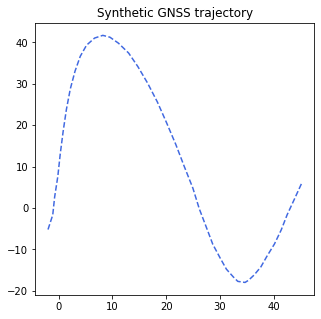

In [3]:
tkl.seed(123)

base_lacets = tkl.generate(0.4, dt=10)
chemin = tkl.noise(base_lacets, 20, tkl.SincKernel(20), direction=tkl.MODE_DIRECTION_ORTHO)[::3]
chemin = chemin[80:250]
chemin.scale(3)

plt.figure(figsize=(5, 5))
plt.plot(chemin.getX(), chemin.getY(), color="royalblue", linestyle='--')
plt.title('Synthetic GNSS trajectory')
plt.show()

## Second : add some noise simulation

1. Coordinate system errors or referencing errors with a Gaussian Kernel
2. GNSS observation errors (auto-correlated in space and time) with a Exponential Kernel
3. White noise process (*e.g.* heat, vibrations, electronic noise) with a DiracKernel which have no scope by definition 

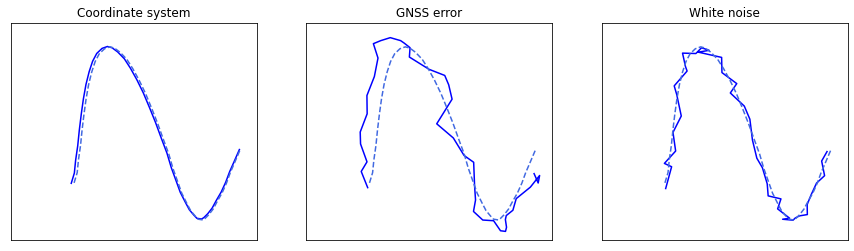

In [4]:
bruit1 = chemin.copy()
bruit1 = bruit1.noise(0.5, tkl.GaussianKernel(100))

bruit2 = chemin.copy()
bruit2 = bruit2.noise(3, tkl.ExponentialKernel(20))

bruit3 = chemin.copy()
bruit3 = bruit3.noise(1, tkl.DiracKernel())

# ----------------------------------------------------------
#   PLOT
def plotNoise(track, i, title):
    ax = plt.subplot2grid((1, 3), (0, i))
    ax.plot(track.getX(), track.getY(), color="blue")
    ax.plot(chemin.getX(), chemin.getY(), color="royalblue", linestyle='--')
    ax.set_title(title)
    ax.set_xlim([-20,50]); ax.set_xticks([])
    ax.set_ylim([-25,50]); ax.set_yticks([])

plt.figure(figsize=(15, 4))
plotNoise(bruit1, 0, 'Coordinate system')
plotNoise(bruit2, 1, 'GNSS error')
plotNoise(bruit3, 2, 'White noise')
plt.show()

## Combine the three error components in the GNSS track

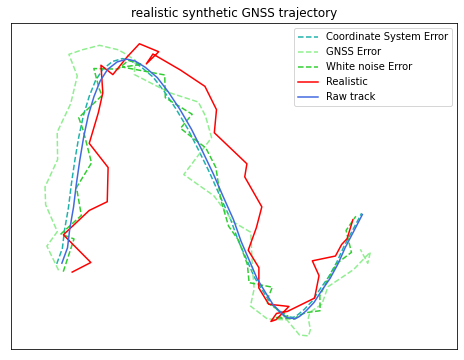

In [5]:
# Combine the  errors
synthetic = chemin.copy()
synthetic = synthetic.noise(0.5, tkl.GaussianKernel(100))
synthetic = synthetic.noise(3, tkl.ExponentialKernel(20))
synthetic = synthetic.noise(1, tkl.DiracKernel())

# ----------------------------------------------------------
plt.figure(figsize=(8, 6))

# Synthetic GNSS trajectory
plt.plot(bruit1.getX(), bruit1.getY(), color="lightseagreen", label='Coordinate System Error', linestyle='--')
plt.plot(bruit2.getX(), bruit2.getY(), color="lightgreen",    label='GNSS Error',              linestyle='--')
plt.plot(bruit3.getX(), bruit3.getY(), color="limegreen",     label='White noise Error',       linestyle='--')
plt.plot(synthetic.getX(), synthetic.getY(), color="red",     label='Realistic',               linestyle='-')
plt.plot(chemin.getX(), chemin.getY(), color="royalblue",     label='Raw track',               linestyle='-')
plt.title('realistic synthetic GNSS trajectory')
plt.xlim([-10,60]); plt.xticks([])
plt.ylim([-25,50]); plt.yticks([])
plt.legend()
plt.show()